# Internal Covariate Shift
- 학습 과정에서 계층별로 입력의 데이터 분포가 달라지는 현상

# Batch Normalization
- 학습 과정에서 각 배치별로 평균과 분산을 이용해 정규화하는 계층을 배치 정규화 계층이라 한다.

### 배치 정규화의 학습 단계
- 정규화로 인해, 모든 계층의 Feature가 동일한 Scale이 되어 학습률 결정에 유리하다.
- 추가적인 Scale, Bias를 학습하여 Activation에 적합한 분포로 변환할 수 있다.

### 배치 정규화의 추론 단계
- 추론 과정에서는 평균과 분산을 이동 평균(또는 지수 평균)하여 고정
- 추론 단계에서는 정규화와 추가 Scale, Bias를 결합하여 단일 곱, 더하기 연산으로 줄일 수 있음.

# GoogLeNET
<br><br>
# Inception 모듈
- 다양한 크기의 합성곱 계층을 한 번에 계산하는 Inception Module
## 1) Bottleneck 구조
- 연산량을 줄이기 위한 1x1 합성곱 계층.
    > 1x1 계층의 장점은 채널을 마음대로 조작할 수 있음. 예를 들어 64채널을 32나 16채널로 줄일 수 있음.<br>
    > 즉, Receptive field를 유지하면서 파라미터의 수와 연산량을 줄임.

## 2) 추가 분류기의 사용 - Better Backpropagation
- 역전파에서 기울기 소실이 발생하는 것을 방지하기 위해, 같은 문제를 여러 단계에서 풀도록 함.

 # Residual Network (ResNet)
- 1) Skip Connection : Feature를 추출하기 전 후를 더하는 특징이 있음.
- 2) Identity Mapping : 
    > 한 단위의 특징 맵을 추출하고 난 후에 활성함수를 적용하는 것이 상식이였다. <br>
    > 하지만 개선된 구조에서는 Identity Mapping을 얻기 위해 Pre-Activation을 제안했다.

- 3) Pre-Activation : 
    > 특정 layer에서 입력이 들어오면, Feature를 뽑을 때, layer 입력을<br>
    > Batch-Normalizaion하고, ReLu를 하고 그 다음 Convolution을 하는 구조 <br>
    - 즉, Conv-Bn-ReLU 구조를 BN - ReLU - Conv 구조로 변경.
        >> Gradient Highway가 형성되어 극적인 효과를 얻음.


# DenseNet
## 구조
- ResNet 아이디어의 연장선에 있으며, Dense Block을 제안하고 있다.
- Dense Block 내에서는 ResNet과 같이, 
    > Pre-Activation 구조 (BN - ReLU - ConV) 구조를 사용한다.

### Dense Block
- 이전 특징 맵에 누적해서 Concatenate하는 결과와 같다.

### Bootleneck 구조
- 레이어가 깊어지면서 연산량이 급격히 증가하는 것을 막기 위해, 1 x 1 Conv를 이용.

### Learning from scratch
    > 구조를 구성해 처음부터 학습하는 것을 위와 같이 표현함.

# Pre-Trained Model과 Fine-Tuning
## 전이 학습 (Transfer Learning)
    > 범용적으로 다양한 물체를 구분하기 위한 ImageNet에 대해 학습된 Feature Map은
    > 대부분의 다른 Task에 대해서도 좋은 성능을 보인다.

### 왜 전이 학습을 사용하는가?
- Dataset 부족의 해결
- 비용 절감
- 학습에 필요한 인력 감소

### Fine-Tuning
> 일반적으로 Knowledge Transfer 해 온 계층들은 Freeze 시켜서 학습하지 않고, 새로운 계층만 학습한다.<br>

> 단, 학습 데이터 셋이 충분히 큰 경우에는 모든 계층을 학습해도 좋다.

# Transfer Learning 사용해보기

### import modules

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### 하이퍼 파라미터 정의

In [4]:
EPOCHS = 100

### 네트워크 구조 정의

In [5]:
def MyModel():
    feat = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False) 

    feat.trainable = False # 네트워크 부분을 학습하지 않게 되어 Freeze 됨.
    
    seq = tf.keras.models.Sequential()
    seq.add(feat) # h x w x channel
    seq.add(tf.keras.layers.GlobalAveragePooling2D()) 
    # Sequential한 부분 모두 pooling 해주고, channel만 남김.

    seq.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # include_top이 False라면, Fully-connected layer 제외하고 Convolutional layer만 포함.
    return seq

### Load data

In [6]:
dataset, meta = tfds.load('cats_vs_dogs',
split=('train[:80%]', 'train[80%:]'), with_info=True, as_supervised=True)
# 최근 tfds.subsplit이 deprecated 되어 사용 불가. 다른 방법 통해 셋을 나누어야함.
train_ds, test_ds = dataset

### 데이터 확인하기

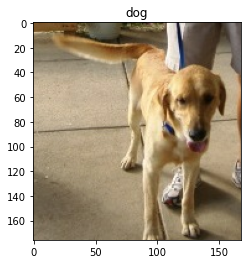

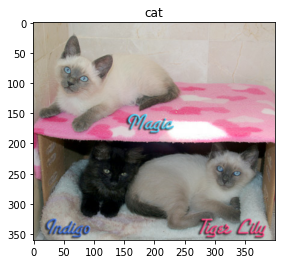

In [7]:
l2s = meta.features['label'].int2str
for img, label in test_ds.take(2):
    plt.figure()
    plt.imshow(img)
    plt.title(l2s(label))
    plt.show()

- 데이터 크기가 달라 Normalize 필요.

### 데이터 가공

In [8]:
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (224, 224))
    return img, label

train_ds = train_ds.map(preprocess).batch(8).prefetch(1024)
test_ds = test_ds.map(preprocess).batch(8).prefetch(1024)

- batch_size가 32면 램 초과, 8로 변경하면 동작.

### 모델 생성

In [9]:
model = MyModel()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### 모델 학습

In [10]:
model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/100
2327/2327 [==============================] - 193s 82ms/step - loss: 0.2543 - accuracy: 0.8921 - val_loss: 0.6697 - val_accuracy: 0.7031
Epoch 2/100
2327/2327 [==============================] - 197s 85ms/step - loss: 0.1827 - accuracy: 0.9251 - val_loss: 0.7521 - val_accuracy: 0.6911
Epoch 3/100
1530/2327 [==================>...........] - ETA: 55s - loss: 0.1756 - accuracy: 0.9269

KeyboardInterrupt: 

- 컴퓨터 과열로 인해 더 이상 수행할 수 없었다.
- 노트북이 아닌 사양이 좋은 데스크탑을 이용하여 돌려볼 예정...